# ATSC-411 - SYNOPTIC METEOROLOGY | FRONTOGENESIS LAB

<br>
<br>
<br>

**************
<br>
<br>
<br>
<br>
<br>
<br>


## IMPORT LIBRARIES

In [1]:
# import packages
import numpy as np                               # numpy for math & number operations
import cartopy.crs as ccrs                       # cartopy coordinate refrence system for mapping -- to turn a matplotlib axis into a geoaxis (map)
import cartopy.feature as cfeature               # cartopy features (borders, states, oceans, rivers, etc) for mapping -- add map components to a map
import matplotlib.pyplot as plt                  # matplotlib for plotting figures, axes, graphs, etc

import helper_functions as helper
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter

print("[+] packages imported...")

[+] packages imported...


**************
<br>
<br>
<br>
<br>
<br>
<br>

## LOAD RAP REANALYSIS DATA FOR A GIVEN DATE

In [27]:
# date/time components
year  = "2021"
month = "12"
day   = "11"
hour  = "12"


# load an `xarray` dataset of RAP reanalysis data
# this will take a few seconds to load
rap_data = helper.give_me_rap_data(year, month, day, hour)


print("\n[+] data load complete...")

> RAP REANALYSIS DATA ACCESS FUNCTION --
-----------------------------------------
> DATASET USED: RAP_13km_anl
> COMPLETE --------
> RUNTIME: 00:00:15

[+] data load complete...


**************
<br>
<br>
<br>
<br>
<br>
<br>

## CONDUCT 2D VARIABLE CALCULATIONS USING METPY TOOLS

#### Compute temperature advection, frontogenesis, 'pressure level slices', and create a tidy date string

In [28]:
#################################
# CALCULATE ADVECTION
################################# 
# using MetPy, compute temperature advection
adv = mpcalc.advection(rap_data['Temperature_isobaric'], 
                       rap_data['u-component_of_wind_isobaric'],
                       rap_data['v-component_of_wind_isobaric'],
                       latitude=rap_data['lon'].values,longitude=rap_data['lon'].values,crs=ccrs.PlateCarree())
# convert units to delta deg C / hr
adv = adv.metpy.convert_units('delta_degC/hour')
# apply some smoothing to adv 
adv = gaussian_filter(adv, sigma=1, order=0) * units('K/sec')




#################################
# CALCULATE FRONTOGENESIS
################################# 
# using MetPy, compute frontogensis
fgen = mpcalc.frontogenesis(rap_data['Temperature_isobaric'], 
                            rap_data['u-component_of_wind_isobaric'],
                            rap_data['v-component_of_wind_isobaric'],
                            latitude=rap_data['lon'].values,longitude=rap_data['lon'].values,crs=ccrs.PlateCarree())
# convert units to delta deg C / 100 km / 3 hr
fgen = fgen.metpy.convert_units('delta_degC/km/hour')*3*100
# create `fgen_masked`, a DataArray of fgen values >2, all else are Nan
fgen_masked = fgen.where(fgen > (2 * units('delta_degC/km/hour')))



#################################
# DEFINE USEFUL PRESSURE LEVEL SLICES
################################# 
# create variables that hold the "index" (location) of a given height in the isobaric dimension
# i.e., 300 hPa is the 8th value in the isobaric dimension, use it to slice other variables
plev850 = list(rap_data['isobaric']).index(((850 * units('hPa')).to(rap_data['isobaric'].units)).m)
plev700 = list(rap_data['isobaric']).index(((700 * units('hPa')).to(rap_data['isobaric'].units)).m)




#################################
# CREATE A TIDY DATE STRING
################################# 
try:
    data_date = rap_data['time'].values[0]
except:
    data_date = rap_data['time1'].values[0]
    pass
valid_date = f'{data_date}'



print("\n[+] plan view data preparation complete...")


[+] plan view data preparation complete...


C:\Users\kyle.gillett\AppData\Local\anaconda3\envs\python10\lib\site-packages\pint\facets\plain\quantity.py:1006: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
C:\Users\kyle.gillett\AppData\Local\anaconda3\envs\python10\lib\site-packages\pint\facets\numpy\numpy_func.py:322: RuntimeWarning: invalid value encountered in arcsin
  result_magnitude = func(*stripped_args, **stripped_kwargs)


**************
<br>
<br>
<br>
<br>
<br>
<br>

## Define the `build_map()` function

In [29]:
#--------------------------------------------------------------------------------------
# BUILD MAPS FUNCTION -----------------------------------------------------------------
#--------------------------------------------------------------------------------------
# define build maps func
def build_map(extent=[-121, -73, 21, 56]):
    
    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=ccrs.LambertConformal())

    # apply the map extent (lat/lon bounding box)
    ax.set_extent(extent)
    # axis aspect ratio
    ax.set_box_aspect(0.7)
    # add map features
    ax.add_feature(cfeature.STATES, edgecolor='navy', alpha=0.5, linestyle='-', linewidth=1, zorder=10)
    ax.add_feature(cfeature.BORDERS, color='navy', alpha=1, linestyle='-', linewidth=1, zorder=11)
    ax.add_feature(cfeature.COASTLINE, color='navy', alpha=0.5, linestyle='-', linewidth=1, zorder=11)

    # apply tight layout to the figure (keeps things tiddy)
    plt.tight_layout()

    # return the figure axis
    return fig, ax

**************
<br>
<br>
<br>
<br>
<br>
<br>


## 850 hPa plan view map of temperature advection and frontogenesis

C:\Users\kyle.gillett\AppData\Local\anaconda3\envs\python10\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '



[+] plotting...


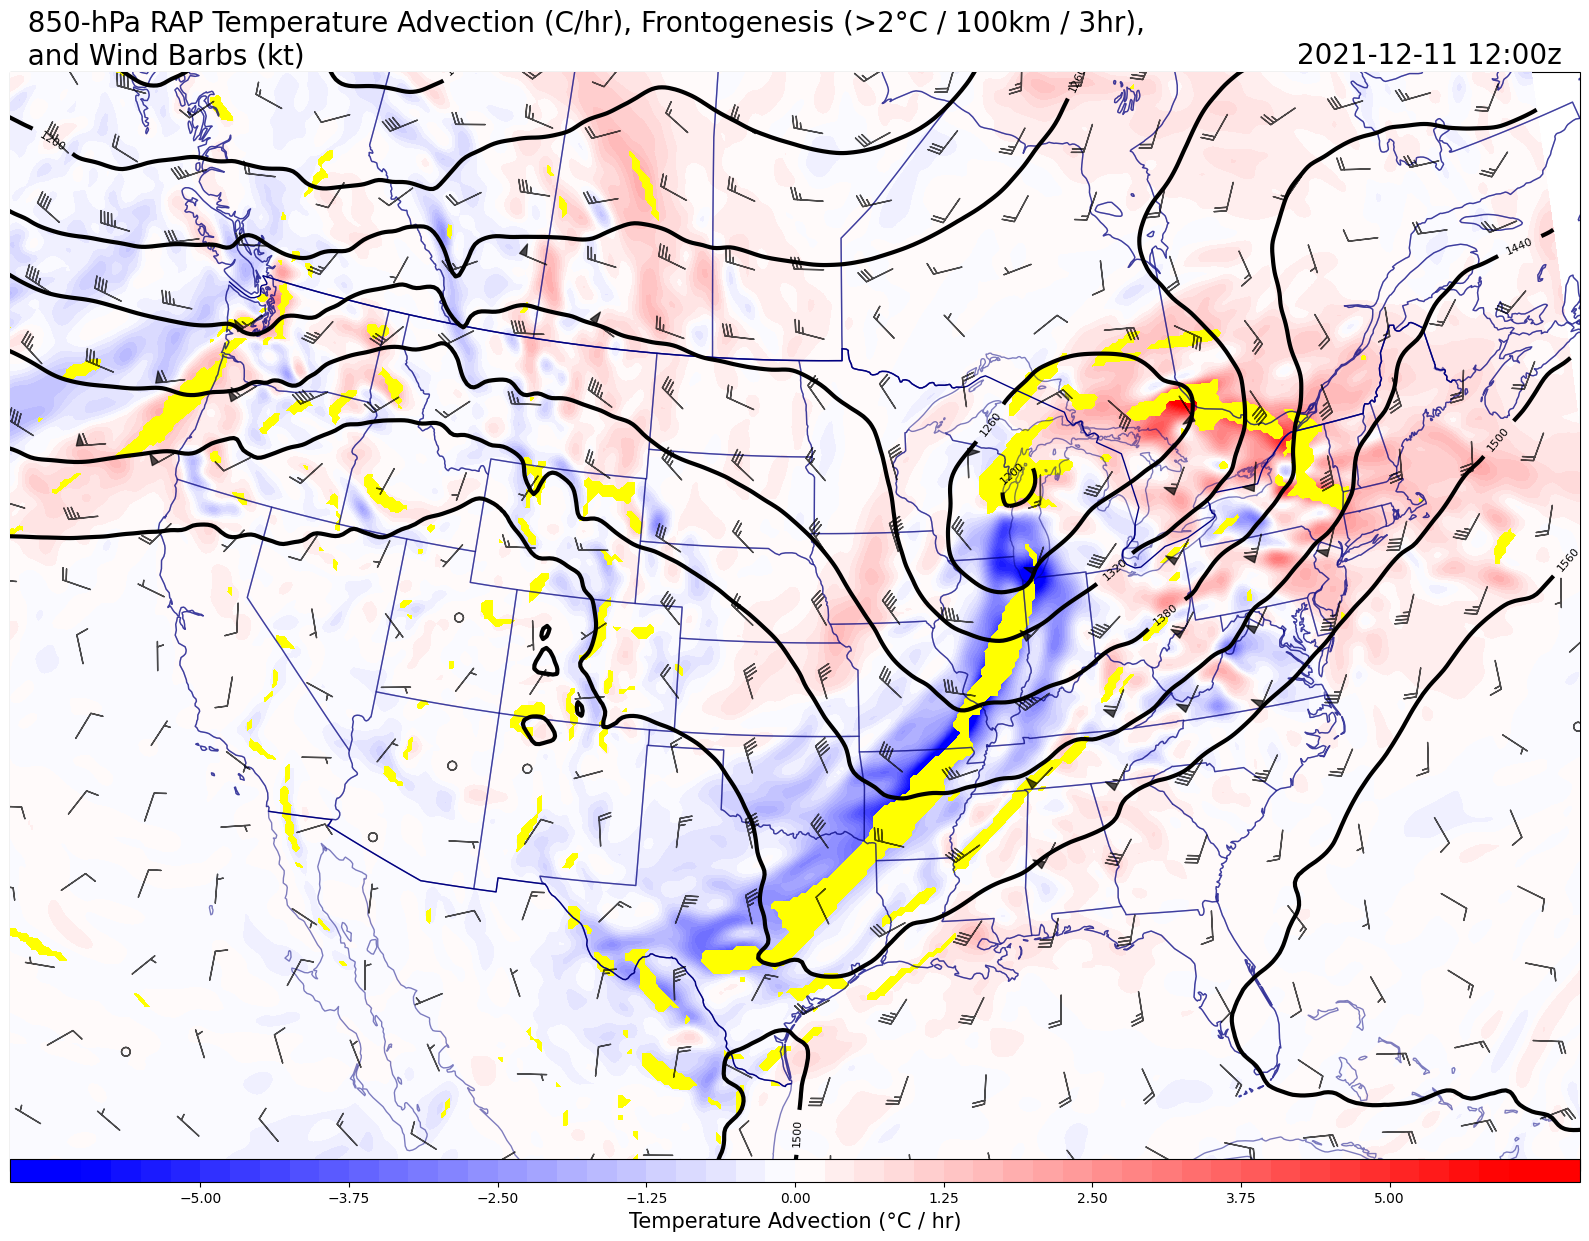

In [30]:
################################
# BUILD AXIS AND FIGURE
#################################
fig, ax = build_map()


# define the level to slice
slice = plev850


#################################
# PLOT DATA ON THE MAP
#################################

# plot filled contour temperature advection 
tadv_contourf = ax.contourf(rap_data['lon'], rap_data['lat'], adv[0,slice,:,:],
                np.arange(-6,6.25,0.25), cmap='bwr', transform=ccrs.PlateCarree(), zorder=4, extend='both')

# plot filled contours pf frontogenesis > 2 delta deg C / hr
fgen_contourf = ax.contourf(rap_data['lon'], rap_data['lat'], fgen_masked[0,slice,:,:],
                 colors='yellow', transform=ccrs.PlateCarree(), zorder=4)


# plot geopotential height contours
contour = ax.contour(rap_data['lon'], rap_data['lat'], rap_data['Geopotential_height_isobaric'][0,slice,:,:], np.arange(0, 12000, 60),
                colors='black', linewidths=3.0, linestyles='-',
                transform=ccrs.PlateCarree(), zorder=11)
plt.clabel(contour, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)


# plot wind barbs
every = 20
barbs = ax.barbs(rap_data['lon'].values[0::every, 0::every], rap_data['lat'].values[0::every, 0::every],
                 rap_data['u-component_of_wind_isobaric'][0,slice,:,:].values[0::every, 0::every]* 1.94384, 
                 rap_data['v-component_of_wind_isobaric'][0,slice,:,:].values[0::every, 0::every]* 1.94384,
                 length=6.5, alpha=0.7, transform=ccrs.PlateCarree(), zorder=12)


# add some plot titles
plt.title('  850-hPa RAP Temperature Advection (C/hr), Frontogenesis (>2'+u'\xb0'+'C / 100km / 3hr),\n'
          '  and Wind Barbs (kt)', loc='left', fontsize=20)
plt.title(f'{valid_date[0:10]} {valid_date[11:-13]}z  ', loc='right', fontsize=20)


# colorbar for filled contour
cbar = plt.colorbar(tadv_contourf, aspect=70, fraction=0.02, ax=ax, orientation='horizontal', pad=-0.01, extendrect=True)
cbar.set_label('Temperature Advection' + ' ('+u'\xb0'+'C / hr)', fontsize=15)

print("\n[+] plotting...")

**************
<br>
<br>
<br>
<br>
<br>
<br>


## 700hPa plan view map of temperature advecton and frontogenesis

C:\Users\kyle.gillett\AppData\Local\anaconda3\envs\python10\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '



[+] plotting...


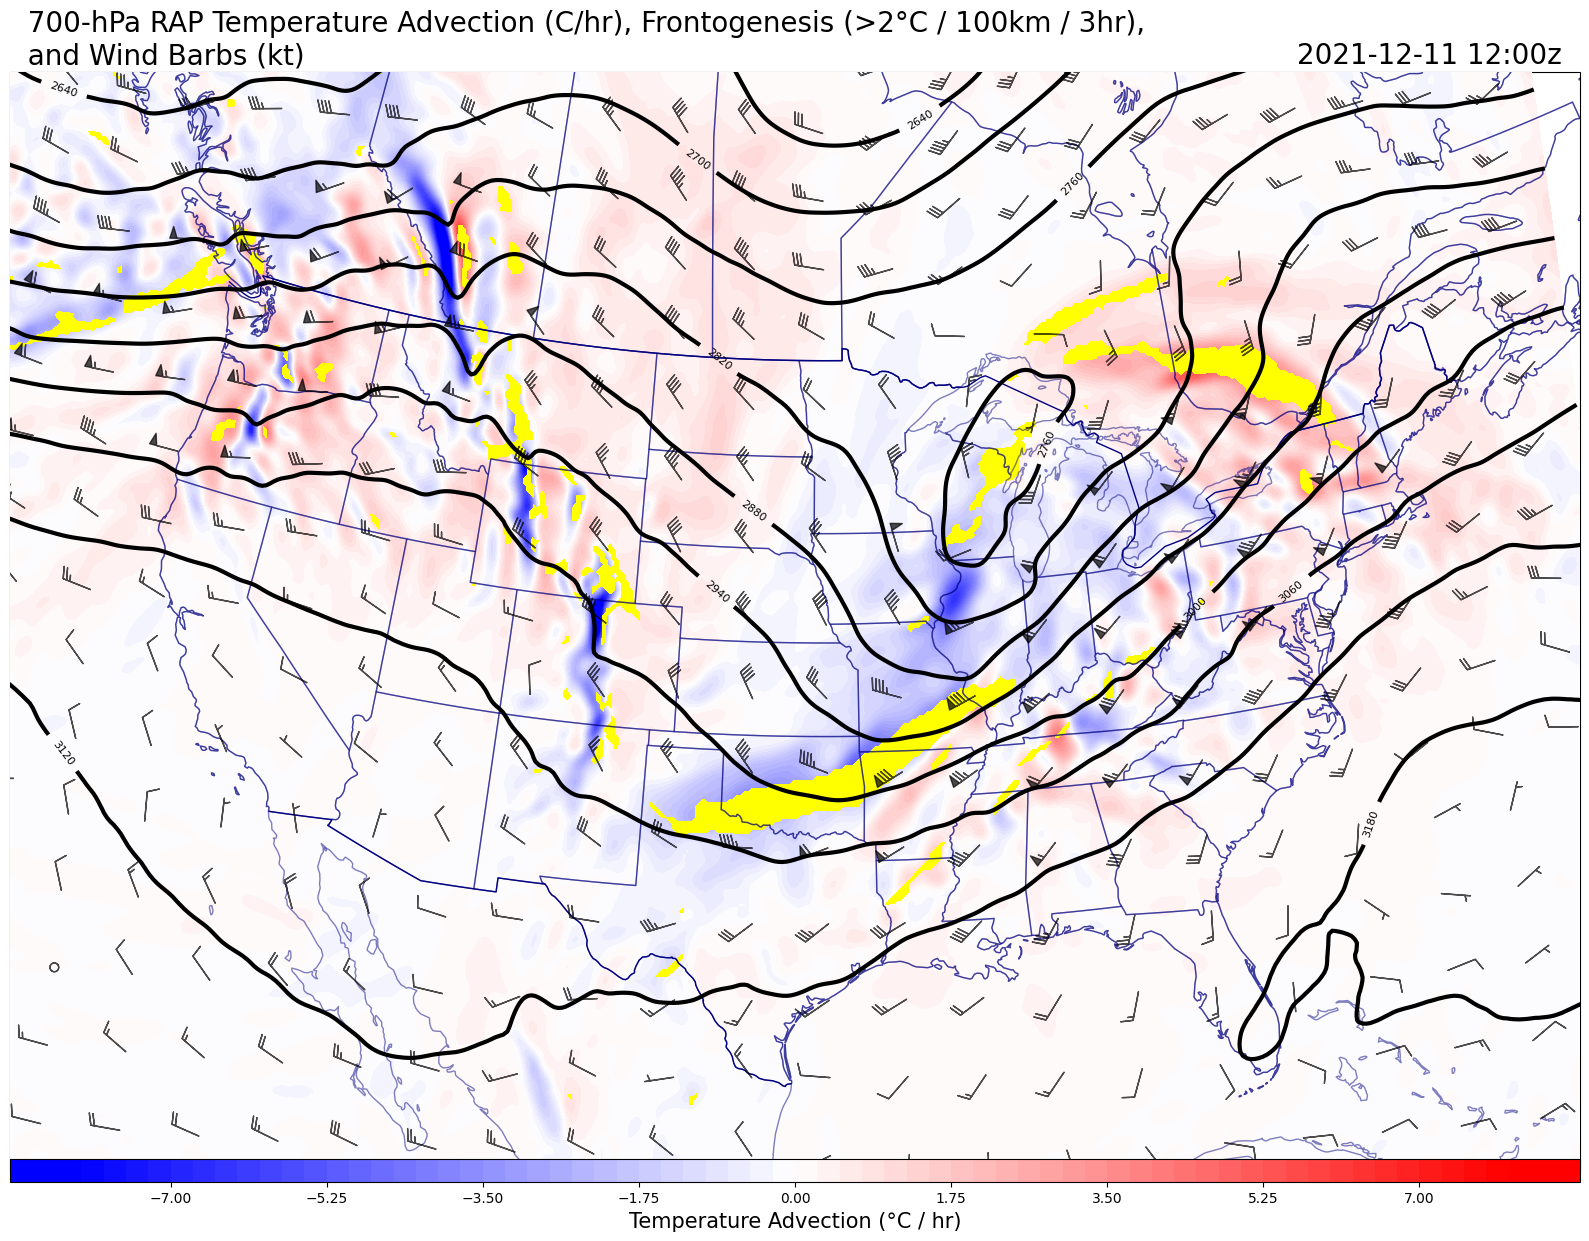

In [31]:
################################
# BUILD AXIS AND FIGURE
#################################
fig, ax = build_map()


# define the level to slice
slice = plev700


#################################
# PLOT DATA ON THE MAP
#################################

# plot filled contour temperature advection 
tadv_contourf = ax.contourf(rap_data['lon'], rap_data['lat'], adv[0,slice,:,:],
                np.arange(-8,8.25,0.25), cmap='bwr', transform=ccrs.PlateCarree(), zorder=4, extend='both')

# plot filled contours pf frontogenesis > 2 delta deg C / hr
fgen_contourf = ax.contourf(rap_data['lon'], rap_data['lat'], fgen_masked[0,slice,:,:],
                 colors='yellow', transform=ccrs.PlateCarree(), zorder=4)


# plot geopotential height contours
contour = ax.contour(rap_data['lon'], rap_data['lat'], rap_data['Geopotential_height_isobaric'][0,slice,:,:], np.arange(0, 12000, 60),
                colors='black', linewidths=3.0, linestyles='-',
                transform=ccrs.PlateCarree(), zorder=11)
plt.clabel(contour, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)


# plot wind barbs
every = 20
barbs = ax.barbs(rap_data['lon'].values[0::every, 0::every], rap_data['lat'].values[0::every, 0::every],
                 rap_data['u-component_of_wind_isobaric'][0,slice,:,:].values[0::every, 0::every]* 1.94384, 
                 rap_data['v-component_of_wind_isobaric'][0,slice,:,:].values[0::every, 0::every]* 1.94384,
                 length=6.5, alpha=0.7, transform=ccrs.PlateCarree(), zorder=12)


# add some plot titles
plt.title('  700-hPa RAP Temperature Advection (C/hr), Frontogenesis (>2'+u'\xb0'+'C / 100km / 3hr),\n'
          '  and Wind Barbs (kt)', loc='left', fontsize=20)
plt.title(f'{valid_date[0:10]} {valid_date[11:-13]}z  ', loc='right', fontsize=20)


# colorbar for filled contour
cbar = plt.colorbar(tadv_contourf, aspect=70, fraction=0.02, ax=ax, orientation='horizontal', pad=-0.01, extendrect=True)
cbar.set_label('Temperature Advection' + ' ('+u'\xb0'+'C / hr)', fontsize=15)

print("\n[+] plotting...")